In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
%matplotlib inline
sns.set_style('whitegrid')
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as img
from itertools import combinations
from scipy.cluster.vq import whiten #Whiten is used to Scale the data
import math

# Data preprocessing

## 1. get RGB value and scale data

In [2]:
def get_scaled_RGB(image, filename):
    b,r,g=[],[],[]
    for row in image:
        for temp_r, temp_g, temp_b in row:
            r.append(int(temp_r))
            g.append(int(temp_g))
            b.append(int(temp_b))
    scaled_red = whiten(r)
    scaled_blue = whiten(b)
    scaled_green = whiten(g)
    df = pd.DataFrame({'name':filename, 'red':r,'blue':b,'green':g,'scaled_red':scaled_red,'scaled_blue':scaled_blue,
                                    'scaled_green':scaled_green})
    return df

## 2. K-means cluster to get dominant colors, k=4

In [3]:
# return dominant colors in RGB
def get_dominant_colors(df):
    X = df[['scaled_red','scaled_green','scaled_blue']]
    kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
    cluster_centers = kmeans.cluster_centers_
    dominant_colors = []
    red_std, green_std, blue_std = df[['red', 'green', 'blue']].std()

    for cluster_center in cluster_centers:
        red_scaled, green_scaled, blue_scaled = cluster_center
        dominant_colors.append((
            int(red_scaled * red_std //1),
        #     blue_scaled * blue_std / 256,
            int(green_scaled * green_std //1),
            int(blue_scaled * blue_std //1)
        ))
    
    return dominant_colors


### Elbow Method to find K

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

## 3. Calculate the average distance of dominant colors

### turn RGB to CIE lab

In [2]:
# RGB to Lab conversion

# Step 1: RGB to XYZ
#         http://www.easyrgb.com/index.php?X=MATH&H=02#text2
# Step 2: XYZ to Lab
#         http://www.easyrgb.com/index.php?X=MATH&H=07#text7


def rgb2lab(inputColor):

    num = 0
    RGB = [0, 0, 0]

    for value in inputColor:
        value = float(value) / 255

        if value > 0.04045:
            value = ((value + 0.055) / 1.055) ** 2.4
        else:
            value = value / 12.92

        RGB[num] = value * 100
        num = num + 1

    XYZ = [0, 0, 0, ]

    X = RGB[0] * 0.4124 + RGB[1] * 0.3576 + RGB[2] * 0.1805
    Y = RGB[0] * 0.2126 + RGB[1] * 0.7152 + RGB[2] * 0.0722
    Z = RGB[0] * 0.0193 + RGB[1] * 0.1192 + RGB[2] * 0.9505
    XYZ[0] = round(X, 4)
    XYZ[1] = round(Y, 4)
    XYZ[2] = round(Z, 4)

    # Observer= 2°, Illuminant= D65
    XYZ[0] = float(XYZ[0]) / 95.047         # ref_X =  95.047
    XYZ[1] = float(XYZ[1]) / 100.0          # ref_Y = 100.000
    XYZ[2] = float(XYZ[2]) / 108.883        # ref_Z = 108.883

    num = 0
    for value in XYZ:

        if value > 0.008856:
            value = value ** (0.3333333333333333)
        else:
            value = (7.787 * value) + (16 / 116)

        XYZ[num] = value
        num = num + 1

    Lab = [0, 0, 0]

    L = (116 * XYZ[1]) - 16
    a = 500 * (XYZ[0] - XYZ[1])
    b = 200 * (XYZ[1] - XYZ[2])

    Lab[0] = round(L, 4)
    Lab[1] = round(a, 4)
    Lab[2] = round(b, 4)

    return Lab


### Calculate the distance in the CIElab space

In [155]:
def distance_CIElab(colors):
    cielab = []
    for color in colors:
        cielab.append(rgb2lab(color))
    cielab = np.array(cielab)[:,1:]

    #only use lab a and lab b to calculate the average distance
    cie_distance = []
    for item in combinations(cielab,2):
        cie_distance.append(distance.euclidean(item[0], item[1]))
    cie_distance = np.array(cie_distance)

    return (cie_distance.mean())


## 4. import image

In [28]:

import os
FILE_FOLDER = "paintings"
NUMBER_OF_PAINTINGS = len(os.listdir(FILE_FOLDER))
TRUNK_SIZE = 100

In [42]:

# cut dataset into trunk, each trunk has 100 paintings

# for i in tqdm(range((NUMBER_OF_PAINTINGS//TRUNK_SIZE)+1)):
i=7
df = pd.DataFrame()
for filename in tqdm(os.listdir(FILE_FOLDER)[i *TRUNK_SIZE : min((i+1) *TRUNK_SIZE, NUMBER_OF_PAINTINGS)]):
    if filename.endswith(".jpg"):
        with open(os.path.join(FILE_FOLDER, filename), 'r') as f:
            image = img.imread(os.path.join(FILE_FOLDER, filename))
            print(filename)
            dominant_colors = get_dominant_colors(get_scaled_RGB(image, filename))
            distance_cie = distance_CIElab(dominant_colors)
            # df_temp = pd.DataFrame({'name':filename, 'dominant_colors': dominant_colors[:], 'distance':distance_cie}, index = count)
            df_temp = pd.DataFrame({'name':filename, 'dominant_colors_0':dominant_colors[:1] , 'dominant_colors_1':dominant_colors[1:2],
                                    'dominant_colors_2':dominant_colors[2:3], 'dominant_colors_3':dominant_colors[3:4],
                                    'distance':distance_cie})
            df = df.append(df_temp)
# df.to_csv('VanGogh_distance_' + str(i) + '.csv')
df.to_pickle('VanGogh_distance_' + str(i) + '.pkl')


  0%|          | 0/58 [00:00<?, ?it/s]

1883_lying-cow-1883.jpg


  2%|▏         | 1/58 [00:11<10:32, 11.09s/it]

1889_sheaf-binder-the-after-millet-1889.jpg


  3%|▎         | 2/58 [00:29<14:12, 15.23s/it]

1888_the-langlois-bridge-at-arles-with-women-washing-1888(1).jpg


  5%|▌         | 3/58 [01:19<28:36, 31.21s/it]

1890_the-grove-1890.jpg


  7%|▋         | 4/58 [01:27<19:49, 22.03s/it]

1889_bloaters-on-a-piece-of-yellow-paper-1889(1).jpg


  9%|▊         | 5/58 [01:42<17:09, 19.43s/it]

1885_autumn-landscape-at-dusk-1885(1).jpg


 10%|█         | 6/58 [01:54<14:46, 17.05s/it]

1888_portrait-of-madame-ginoux-l-arlesienne-1888-1.jpg


 12%|█▏        | 7/58 [02:13<15:06, 17.77s/it]

1889_flowering-shrubs-1889(1).jpg


 14%|█▍        | 8/58 [02:19<11:40, 14.01s/it]

1888_three-white-cottages-in-saintes-maries-1888.jpg


 16%|█▌        | 9/58 [02:26<09:36, 11.77s/it]

1886_view-of-paris-from-montmartre-1886.jpg


 17%|█▋        | 10/58 [02:52<12:58, 16.21s/it]

1888_portrait-of-a-man-1888.jpg


 19%|█▉        | 11/58 [03:06<12:01, 15.34s/it]

1885_autumn-landscape-with-four-trees-1885(1).jpg


 21%|██        | 12/58 [03:30<13:54, 18.13s/it]

1887_le-moulin-de-la-gallette-1887.jpg


 22%|██▏       | 13/58 [03:36<10:46, 14.37s/it]

1889_peasant-woman-cutting-straw-after-millet-1889.jpg


 24%|██▍       | 14/58 [03:54<11:20, 15.47s/it]

1887_portrait-of-the-art-dealer-alexander-reid-sitting-in-an-easy-chair.jpg


 26%|██▌       | 15/58 [03:59<08:55, 12.46s/it]

1888_portrait-of-camille-roulin-1888-1.jpg


 28%|██▊       | 16/58 [04:02<06:33,  9.37s/it]

1886_plaster-statuette-of-a-female-torso.jpg


 29%|██▉       | 17/58 [04:38<12:00, 17.59s/it]

1889_the-garden-of-saint-paul-hospital-1889-2.jpg


 31%|███       | 18/58 [05:01<12:45, 19.14s/it]

1886_sloping-path-in-montmartre-1886.jpg


 33%|███▎      | 19/58 [05:33<14:52, 22.88s/it]

1888_the-langlois-bridge-at-arles-1888-2.jpg


 34%|███▍      | 20/58 [05:50<13:23, 21.14s/it]

1888_portrait-of-the-postman-joseph-roulin.jpg


 36%|███▌      | 21/58 [06:02<11:21, 18.42s/it]

1889_field-with-two-rabbits-1889(1).jpg


 38%|███▊      | 22/58 [06:11<09:18, 15.53s/it]

1890_two-peasant-women-digging-in-field-with-snow-1890.jpg


 40%|███▉      | 23/58 [06:47<12:39, 21.69s/it]

1885_portrait-of-an-old-man-with-beard-1885.jpg


 41%|████▏     | 24/58 [07:08<12:12, 21.53s/it]

1887_montmartre-path-with-sunflowers-1887.jpg


 43%|████▎     | 25/58 [07:13<09:09, 16.64s/it]

1887_antique-3937521.jpg


 45%|████▍     | 26/58 [08:12<15:36, 29.28s/it]

1888_a-pair-of-lovers-arles-1888(1).jpg


 47%|████▋     | 27/58 [08:14<10:54, 21.12s/it]

1887_still-life-with-three-books-1887.jpg


 48%|████▊     | 28/58 [08:26<09:11, 18.39s/it]

1885_still-life-with-vegetables-and-fruit-1885.jpg


 50%|█████     | 29/58 [08:33<07:11, 14.86s/it]

1888_red-vineyards-at-arles-1888.jpg


 52%|█████▏    | 30/58 [08:55<08:02, 17.23s/it]

1889_wheat-field-with-cypresses-1889.jpg


 53%|█████▎    | 31/58 [09:01<06:09, 13.68s/it]

1885_still-life-with-an-earthern-bowl-and-potatoes-1885.jpg


 55%|█████▌    | 32/58 [09:04<04:35, 10.58s/it]

1889_window-of-vincent-s-studio-at-the-asylum-1889.jpg


 57%|█████▋    | 33/58 [09:09<03:44,  8.98s/it]

1888_selfportrait-on-the-road-to-tarascon-the-painter-on-his-way-to-work-1888.jpg


 59%|█████▊    | 34/58 [09:28<04:45, 11.91s/it]

1890_green-wheat-fields-1890(1).jpg


 60%|██████    | 35/58 [09:36<04:09, 10.84s/it]

1889_olive-trees-1889.jpg


 62%|██████▏   | 36/58 [09:53<04:34, 12.50s/it]

1887_view-of-paris-from-vincent-s-room-in-the-rue-lepic-1887.jpg


 64%|██████▍   | 37/58 [10:12<05:07, 14.63s/it]

1888_still-life-vase-with-fifteen-sunflowers-1888.jpg


 66%|██████▌   | 38/58 [11:00<08:12, 24.62s/it]

1884_two-rats-1884.jpg


 67%|██████▋   | 39/58 [11:03<05:42, 18.05s/it]

1887_still-life-with-grapes-pears-and-lemons-1887-1.jpg


 69%|██████▉   | 40/58 [11:17<05:00, 16.71s/it]

1887_restaurant-de-la-sirene-at-asnieres-1887-1.jpg


 71%|███████   | 41/58 [11:54<06:27, 22.77s/it]

1889_madame-roulin-rocking-the-cradle-a-lullaby-1889.jpg


 72%|███████▏  | 42/58 [12:15<05:56, 22.27s/it]

1890_blossoming-acacia-branches-1890(1).jpg


 74%|███████▍  | 43/58 [12:20<04:18, 17.23s/it]

1888_trunk-of-an-old-yew-tree-1888.jpg


 76%|███████▌  | 44/58 [12:36<03:53, 16.69s/it]

1888_mother-roulin-with-her-baby-1888.jpg


 78%|███████▊  | 45/58 [12:47<03:17, 15.22s/it]

1888_portrait-of-a-one-eyed-man-1888.jpg


 79%|███████▉  | 46/58 [13:00<02:52, 14.36s/it]

1888_wheat-stacks-with-reaper-1888.jpg


 81%|████████  | 47/58 [13:09<02:21, 12.84s/it]

1890_portrait-of-madame-ginoux-l-arlesienne-1890.jpg


 83%|████████▎ | 48/58 [13:19<01:58, 11.86s/it]

1885_head-of-a-peasant-with-a-pipe-1885(1).jpg


 84%|████████▍ | 49/58 [13:35<01:59, 13.23s/it]

1888_portrait-of-armand-roulin-1888-1.jpg


 86%|████████▌ | 50/58 [13:42<01:31, 11.42s/it]

1885_lane-with-poplars-near-nuenen-1885.jpg


 88%|████████▊ | 51/58 [14:08<01:50, 15.72s/it]

1885_head-of-a-peasant-study-for-the-potato-eaters-1885(1).jpg


 90%|████████▉ | 52/58 [14:13<01:16, 12.67s/it]

1887_antique-3840757.jpg


 91%|█████████▏| 53/58 [17:36<05:47, 69.54s/it]

1886_vase-with-zinnias-and-geraniums-1886.jpg


 93%|█████████▎| 54/58 [18:00<03:44, 56.11s/it]

1889_the-garden-of-saint-paul-hospital-1889-1.jpg


 95%|█████████▍| 55/58 [18:09<02:05, 41.80s/it]

1889_two-peasants-diging-after-millet-1889.jpg


 97%|█████████▋| 56/58 [18:17<01:03, 31.80s/it]

1887_vase-with-white-and-red-carnations-1887.jpg


 98%|█████████▊| 57/58 [18:23<00:23, 23.98s/it]

1886_still-life-with-mackerels-lemons-and-tomatoes-1886.jpg


100%|██████████| 58/58 [18:29<00:00, 19.14s/it]


# Data analysis

## 1. get the distribution of distance 

### get the distribution of distance over month

In [3]:
df = pd.DataFrame()
for i in range(7):
    temp = pd.read_pickle('image_data/VanGogh_distance_'+str(i)+'.pkl')
    df = pd.concat([df,temp], ignore_index = True)

# df = df.reset_index()
df

,name,dominant_colors_0,dominant_colors_1,dominant_colors_2,dominant_colors_3,distance
0,1888_starry-night-over-the-rhone.jpg,"(34, 77, 104)","(183, 206, 192)","(10, 29, 42)","(92, 131, 141)",14.303365
1,1889_the-gully-peiroulets-1889.jpg,"(151, 162, 123)","(115, 107, 57)","(61, 64, 28)","(191, 150, 60)",19.780258
2,1888_flowering-garden-1888(1).jpg,"(182, 140, 34)","(169, 189, 153)","(43, 45, 18)","(103, 90, 29)",27.041082
3,1889_two-diggers-among-trees-1889.jpg,"(185, 205, 166)","(104, 109, 67)","(45, 50, 33)","(158, 156, 97)",12.587401
4,1890_the-fields-1890.jpg,"(155, 126, 43)","(97, 115, 138)","(68, 61, 43)","(216, 186, 70)",43.575713
...,...,...,...,...,...,...
690,1889_evening-the-end-of-the-day-after-millet-1...,"(207, 183, 74)","(148, 132, 53)","(92, 82, 34)","(37, 33, 10)",23.591404
691,1889_still-life-vase-with-twelve-sunflowers.jpg,"(150, 105, 32)","(132, 213, 214)","(232, 162, 53)","(55, 52, 19)",46.302148
692,1885_still-life-with-an-earthern-bowl-and-pear...,"(78, 75, 63)","(178, 179, 142)","(109, 104, 83)","(57, 55, 48)",8.606299
693,1887_park-at-asnieres-in-spring-1887.jpg,"(37, 47, 19)","(201, 202, 119)","(86, 101, 45)","(156, 152, 59)",18.125702


In [4]:
df1 = pd.read_csv('image_data/VanGogh_distance_all_month.csv')
df1['month'].unique()
df1 = df1[df1['month'].notna()]
# df_month = df1[df1['month'].notna()].groupby(['month'])['distance'].mean()
# df1.iloc[500]['month']
df1[df1['month'] =='1889-04']


,Unnamed: 0,name,dominant_colors_0,dominant_colors_1,dominant_colors_2,dominant_colors_3,distance,year,id,month
473,473,1889_avenue-with-flowering-chestnut-trees-at-a...,"(205, 194, 125)","(28, 32, 27)","(130, 125, 93)","(76, 78, 57)",17.765410,1889,473,1889-04
479,479,1889_portrait-of-the-postman-joseph-roulin-188...,"(60, 59, 56)","(201, 173, 117)","(100, 107, 77)","(16, 16, 12)",18.966703,1889,479,1889-04
480,480,1889_ward-in-the-hospital-at-arles-1889.jpg,"(126, 139, 87)","(173, 121, 39)","(184, 199, 140)","(72, 62, 25)",21.829685,1889,480,1889-04
504,504,1889_the-courtyard-of-the-hospital-in-arles-18...,"(36, 33, 40)","(194, 160, 58)","(177, 178, 147)","(111, 108, 69)",31.716451,1889,504,1889-04
505,505,1889_clumps-of-grass-1889(1).jpg,"(132, 156, 92)","(47, 61, 19)","(201, 209, 163)","(90, 117, 48)",10.043577,1889,505,1889-04
521,521,1889_portrait-of-the-postman-joseph-roulin-188...,"(74, 88, 43)","(26, 25, 17)","(131, 141, 63)","(205, 201, 132)",21.022889,1889,521,1889-04
524,524,1889_rosebush-in-blossom-1889.jpg,"(154, 135, 88)","(38, 23, 15)","(215, 196, 167)","(101, 78, 49)",11.486916,1889,524,1889-04
531,531,1889_a-field-of-yellow-flowers-1889(1).jpg,"(210, 186, 81)","(88, 59, 10)","(151, 130, 24)","(202, 174, 34)",19.044731,1889,531,1889-04
581,581,1889_orchard-in-bloom-with-poplars-1889.jpg,"(171, 156, 134)","(60, 38, 25)","(238, 228, 211)","(123, 102, 68)",8.772224,1889,581,1889-04


In [5]:
df_month = df1.groupby('month')['distance'].mean()

In [6]:
df_month_number = df1.groupby('month')['year'].count()
df_month_number = df_month_number.to_frame()
df_month_number = df_month_number.reset_index()
df_month_number = df_month_number.append({'month':'1889-02', 'year':0}, ignore_index=True)

In [7]:
df_month_number = df_month_number.sort_values(by = ['month']).reset_index()

In [8]:
#df_month_number = df_month_number
# df_month_number = 
df_month_number.rename(columns = {'year':'number'},inplace = True)

In [9]:
df_month_number

,index,month,number
0,0,1888-02,6
1,1,1888-03,13
2,2,1888-04,10
3,3,1888-05,9
4,4,1888-06,21
5,5,1888-07,6
6,6,1888-08,21
7,7,1888-09,13
8,8,1888-10,11
9,9,1888-11,6


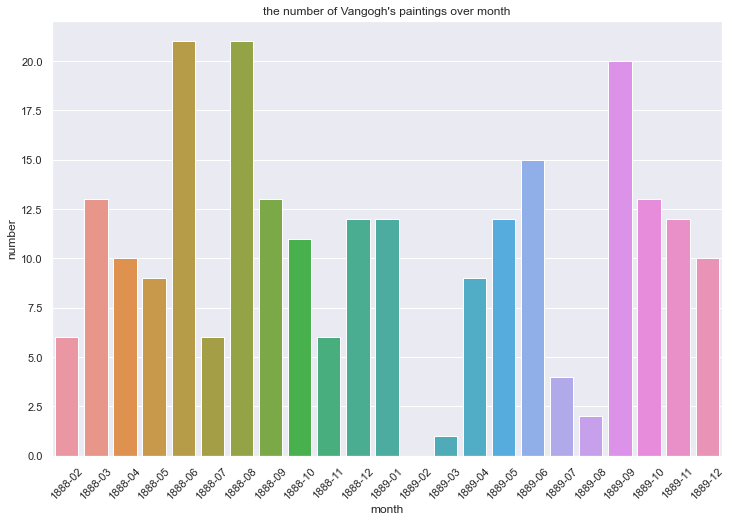

In [10]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(data = df_month_number, x='month', y ='number').set(title = 'the number of Vangogh\'s paintings over month')
plt.xticks(rotation=45)
plt.show()

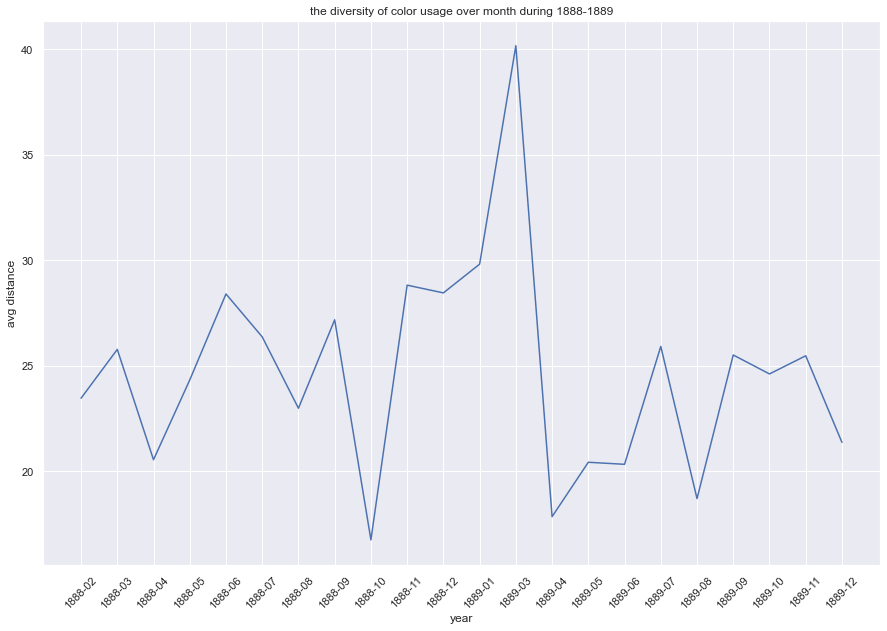

In [11]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(x=df_month.index, y=df_month.values).set(
                    xlabel = 'year', ylabel = 'avg distance', title = 'the diversity of color usage over month during 1888-1889')
# sns.lineplot(x='month', y='distance', ci = 'sd', err_style="band", data =df1).set(title = 'the diversity of color usage over year with std')
plt.xticks(rotation=45)
plt.show()

### get the distribution of distance over year

In [12]:
df['year'] = df['name'].map(lambda t: t.split("_")[0])

In [13]:
df = df.sort_values(by = ['year']).reset_index(drop = True)
df['id'] = df.index
df

,name,dominant_colors_0,dominant_colors_1,dominant_colors_2,dominant_colors_3,distance,year,id
0,1881_still-life-with-beer-mug-and-fruit-1881.jpg,"(15, 11, 6)","(26, 22, 18)","(55, 34, 28)","(132, 75, 46)",17.983233,1881,0
1,1881_still-life-with-cabbage-and-clogs-1881.jpg,"(120, 97, 61)","(68, 67, 54)","(205, 182, 111)","(162, 136, 80)",17.740407,1881,1
2,1881_windmils-at-dordrecht-1881.jpg,"(60, 47, 39)","(179, 147, 103)","(220, 194, 145)","(120, 98, 71)",12.544916,1881,2
3,1882_girl-in-white-in-the-woods-1882(1).jpg,"(29, 17, 15)","(147, 78, 51)","(199, 144, 76)","(84, 46, 36)",26.237820,1882,3
4,1882_view-of-the-sea-at-scheveningen-1882.jpg,"(198, 177, 139)","(60, 40, 22)","(157, 129, 91)","(113, 86, 57)",6.182227,1882,4
...,...,...,...,...,...,...,...,...
690,1890_thatched-sandstone-cottages-in-chaponval-...,"(37, 55, 45)","(194, 218, 209)","(150, 164, 125)","(89, 107, 75)",10.678202,1890,690
691,1890_daubigny-s-garden-1890-1(1).jpg,"(79, 110, 25)","(209, 198, 103)","(42, 68, 10)","(134, 145, 56)",14.199461,1890,691
692,1890_the-church-at-auvers-1890.jpg,"(161, 139, 54)","(42, 82, 136)","(32, 41, 28)","(219, 200, 139)",45.455715,1890,692
693,1890_blossoming-chestnut-branches-1890(1).jpg,"(80, 115, 169)","(25, 34, 19)","(195, 203, 169)","(107, 118, 55)",35.247702,1890,693


In [14]:
df['id'] = df.index

[Text(0.5, 1.0, "the number of Vangogh's paintings")]

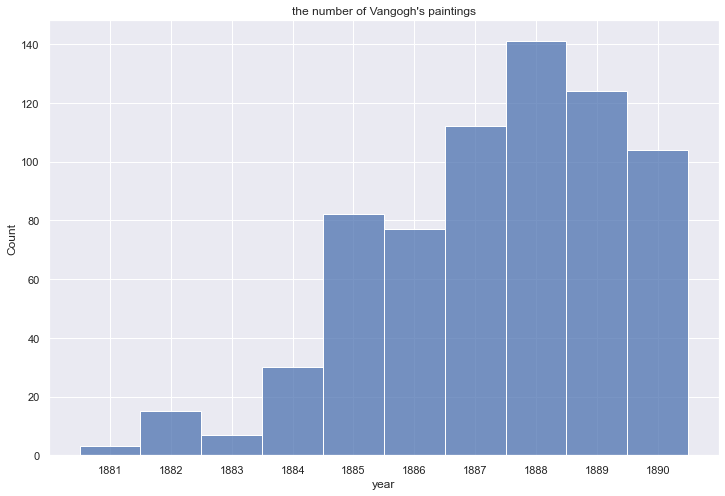

In [15]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data = df, x='year').set(title = 'the number of Vangogh\'s paintings')

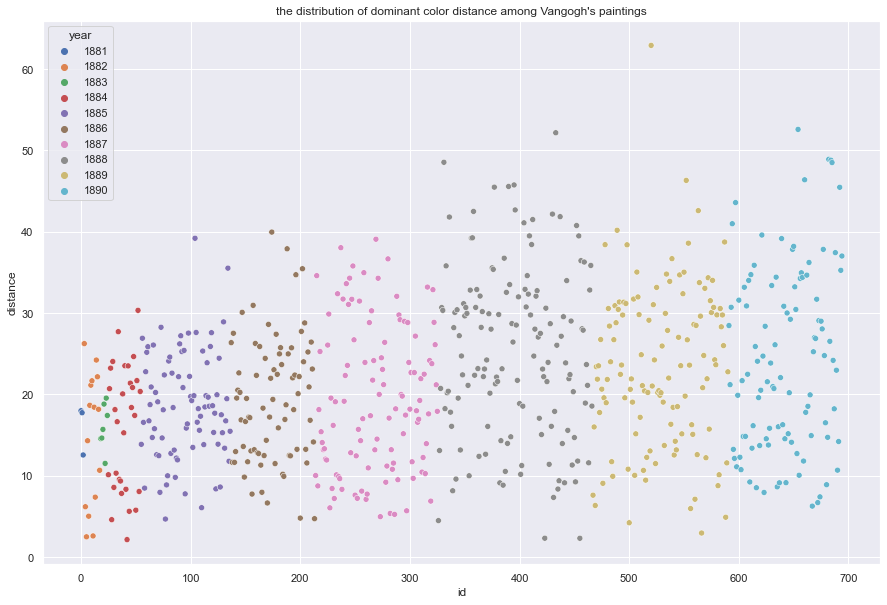

In [16]:
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x='id', y="distance",hue='year', data=df).set(title = 'the distribution of dominant color distance among Vangogh\'s paintings')
plt.show()

[Text(0.5, 0, 'year'),
 Text(0, 0.5, 'avg distance'),
 Text(0.5, 1.0, 'the diversity of color usage over year')]

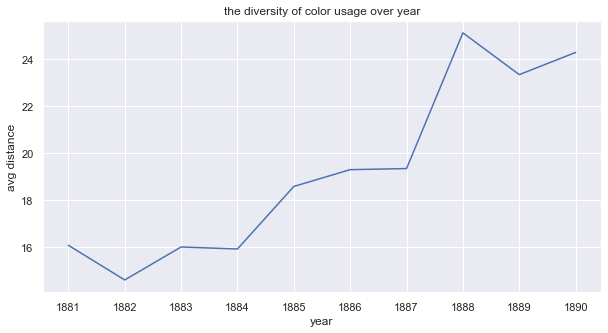

In [17]:
df_year = df.groupby(['year'])['distance'].mean()
sns.set(rc={'figure.figsize':(10,5)})
# sns.barplot(x='A', y='B', data=df_2);
sns.lineplot(x=df_year.index, y=df_year.values,markers = True).set(
                    xlabel = 'year', ylabel = 'avg distance', title = 'the diversity of color usage over year')

[Text(0.5, 1.0, 'the diversity of color usage over year with std')]

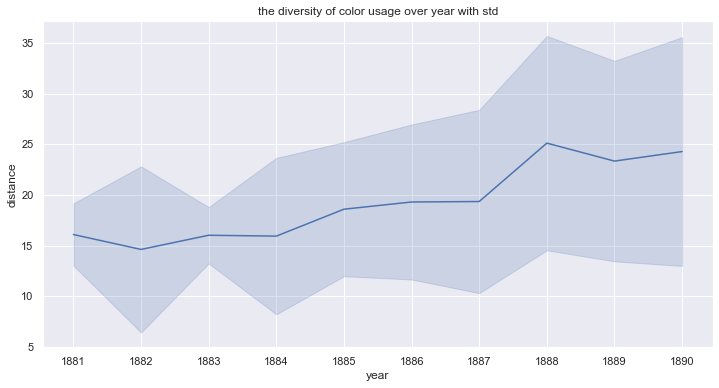

In [18]:
sns.set(rc={'figure.figsize':(12,6)})
sns.lineplot(x='year', y='distance', ci = 'sd', err_style="band", data =df).set(title = 'the diversity of color usage over year with std')

## 2. the change of dominant colors

In [19]:
def RGB_value(a):
    value = a[0] * np.power(16,6) + a[1] * np.power(16,4) + a[2] * np.power(16,2)
    CIE_colors = []
    b = rgb2lab(a)
    angle = math.atan2(b[1] , b[2])
    return angle

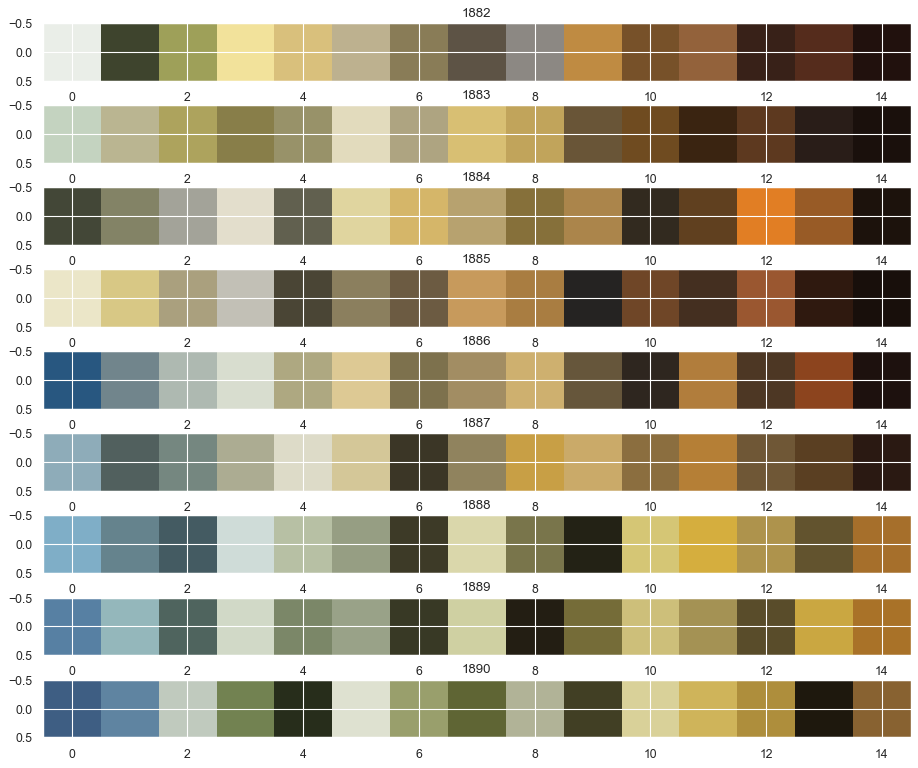

In [20]:
plt.figure(figsize=(14, 12), dpi=80)
for year in range(1882, 1891, 1):
    df_temp = df[df['year'] == str(year)]
    colors = []
    for index, row in df_temp.iterrows():
        colors.append(row['dominant_colors_0'])
        colors.append(row['dominant_colors_1'])
        colors.append(row['dominant_colors_2'])
        colors.append(row['dominant_colors_3'])

    colors = np.array(colors)
    colors = colors/255

    kmeans = KMeans(n_clusters=15, random_state=0).fit(colors)
    cluster_centers = kmeans.cluster_centers_
    dominant_colors = []
    plt.subplot(9,1,year-1881)
    plt.imshow([sorted(cluster_centers.tolist(), key = RGB_value)])
    plt.title(year)

plt.show()


## 3. the change of lightness over year

In [21]:
def get_lightness(row):
    CIE_colors = []
    CIE_colors.append(rgb2lab(row['dominant_colors_0']))
    CIE_colors.append(rgb2lab(row['dominant_colors_1']))
    CIE_colors.append(rgb2lab(row['dominant_colors_2']))
    CIE_colors.append(rgb2lab(row['dominant_colors_3']))
    CIE_colors = np.array(CIE_colors)
    return CIE_colors[:,0].mean()

In [22]:
df['lightness'] = df.apply(get_lightness, axis = 1)
# df[df['distance']<20]

[Text(0.5, 1.0, 'the lightness of color usage over year with std')]

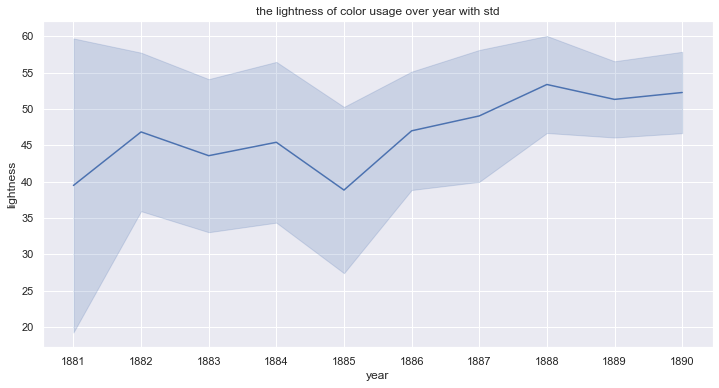

In [23]:
sns.set(rc={'figure.figsize':(12,6)})
sns.lineplot(x='year', y='lightness', ci = 'sd', err_style="band", data =df[df['distance']<20]).set(title = 'the lightness of color usage over year with std')

[Text(0.5, 1.0, 'the lightness of color usage over year with std')]

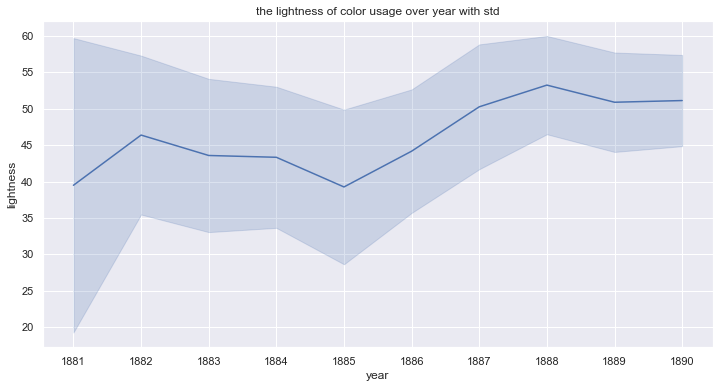

In [26]:
#for monochromatic paintings
sns.set(rc={'figure.figsize':(12,6)})
sns.lineplot(x='year', y='lightness', ci = 'sd', err_style="band", data =df).set(title = 'the lightness of color usage over year with std')